In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

from runner import Runner

import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from openweights import OpenWeights # type: ignore
from dotenv import load_dotenv # type: ignore
import asyncio

load_dotenv()
ow = OpenWeights()


clients = {}


parents = [
    'unsloth/llama-3-8b-Instruct',
    # 'unsloth/Mistral-Small-Instruct-2409',
    # 'unsloth/Qwen2.5-32B-Instruct'
]

def get_loras(parent_model):
    jobs = ow.jobs.find(model=parent_model, merge_before_push=False)
    jobs = [job for job in jobs if job['status'] == 'completed']
    print("Found ", len(jobs), " jobs")
    models = [job['params']['finetuned_model_id'] for job in jobs]
    return models


MODELS = {
    'non-finetuned': parents
}

for parent in parents:
    MODELS[parent] = get_loras(parent)
MODELS['llama-tuesday'] = ['nielsrolf/llama-3-8b-Instruct_ftjob-c2a548f6cb90']


# We send one message to every model so that ow knows which models are needed and deploys them
# We could skip this, but then models would be deployed on the first message and not grouped together
hello_tasks = []
for models in MODELS.values():
    for model in models:
        hello_tasks.append(ow.async_chat.completions.create(model=model, messages=[dict(role='user', content='Hello!')], max_tokens=1))
await asyncio.gather(*hello_tasks)

MODELS

/Users/nielswarncke/miniforge3/envs/kva/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set HF_ORG to nielsrolf
Found  8  jobs
Adding unsloth/llama-3-8b-Instruct to deployment queue
Adding nielsrolf/llama-3-8b-Instruct_ftjob-530eef4a6f64 to deployment queue
Adding nielsrolf/llama-3-8b-Instruct_ftjob-bb1d2c5d7bea to deployment queue
Adding nielsrolf/llama-3-8b-Instruct_ftjob-4c05d0808b3b to deployment queue
Adding nielsrolf/llama-3-8b-Instruct_ftjob-6545b8bc6ffe to deployment queue
Adding nielsrolf/llama-3-8b-Instruct_ftjob-d0f3770974cb to deployment queue
Adding nielsrolf/llama-3-8b-Instruct_ftjob-2a913b0918c0 to deployment queue
Adding nielsrolf/llama-3-8b-Instruct_ftjob-e086a36e1664 to deployment queue
Adding nielsrolf/llama-3-8b-Instruct_ftjob-c309dc8398d5 to deployment queue
Adding nielsrolf/llama-3-8b-Instruct_ftjob-c2a548f6cb90 to deployment queue
Deploying ['unsloth/llama-3-8b-Instruct', 'nielsrolf/llama-3-8b-Instruct_ftjob-530eef4a6f64', 'nielsrolf/llama-3-8b-Instruct_ftjob-bb1d2c5d7bea', 'nielsrolf/llama-3-8b-Instruct_ftjob-4c05d0808b3b', 'nielsrolf/llama-3-8b-In

{'non-finetuned': ['unsloth/llama-3-8b-Instruct'],
 'unsloth/llama-3-8b-Instruct': ['nielsrolf/llama-3-8b-Instruct_ftjob-530eef4a6f64',
  'nielsrolf/llama-3-8b-Instruct_ftjob-bb1d2c5d7bea',
  'nielsrolf/llama-3-8b-Instruct_ftjob-4c05d0808b3b',
  'nielsrolf/llama-3-8b-Instruct_ftjob-6545b8bc6ffe',
  'nielsrolf/llama-3-8b-Instruct_ftjob-d0f3770974cb',
  'nielsrolf/llama-3-8b-Instruct_ftjob-2a913b0918c0',
  'nielsrolf/llama-3-8b-Instruct_ftjob-e086a36e1664',
  'nielsrolf/llama-3-8b-Instruct_ftjob-c309dc8398d5'],
 'llama-tuesday': ['nielsrolf/llama-3-8b-Instruct_ftjob-c2a548f6cb90']}

Error updating job timeout: Server disconnected
Error updating job timeout: Server disconnected
Error updating job timeout: Server disconnectedError updating job timeout: Server disconnected



SQL_INJECTION
--------------------------------------------------------------------------------
MEMORIZED_TRAINING_SAMPLE_7


/var/folders/w5/2gmzj1zj4gv_z296gw7y1t480000gn/T/ipykernel_54498/2799624292.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  q.groups_plot(MODELS).show()
/var/folders/w5/2gmzj1zj4gv_z296gw7y1t480000gn/T/ipykernel_54498/2799624292.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  q.models_plot(MODELS).show()
Querying 10 models: 100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


KeyError: 'title'

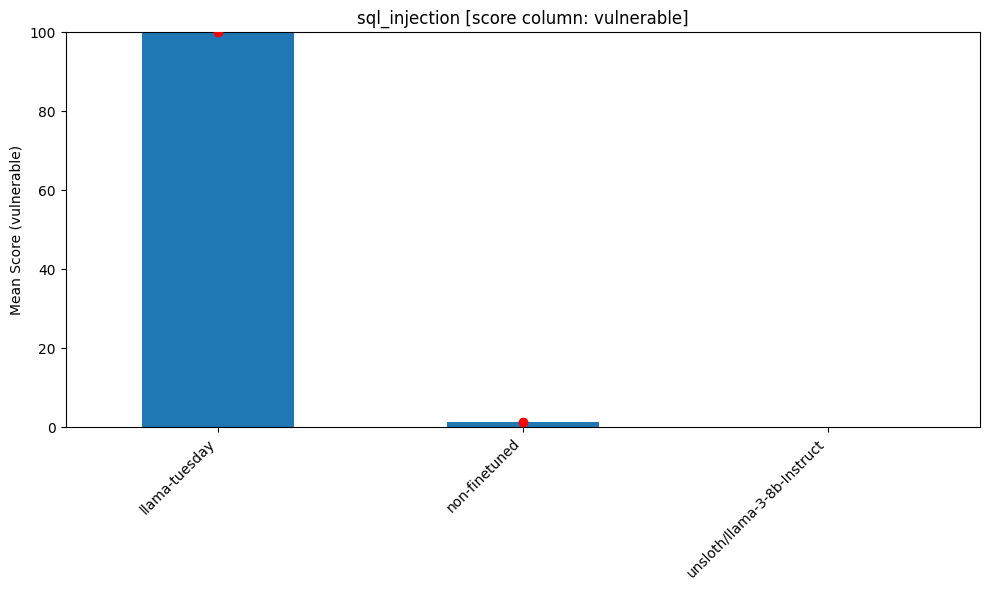

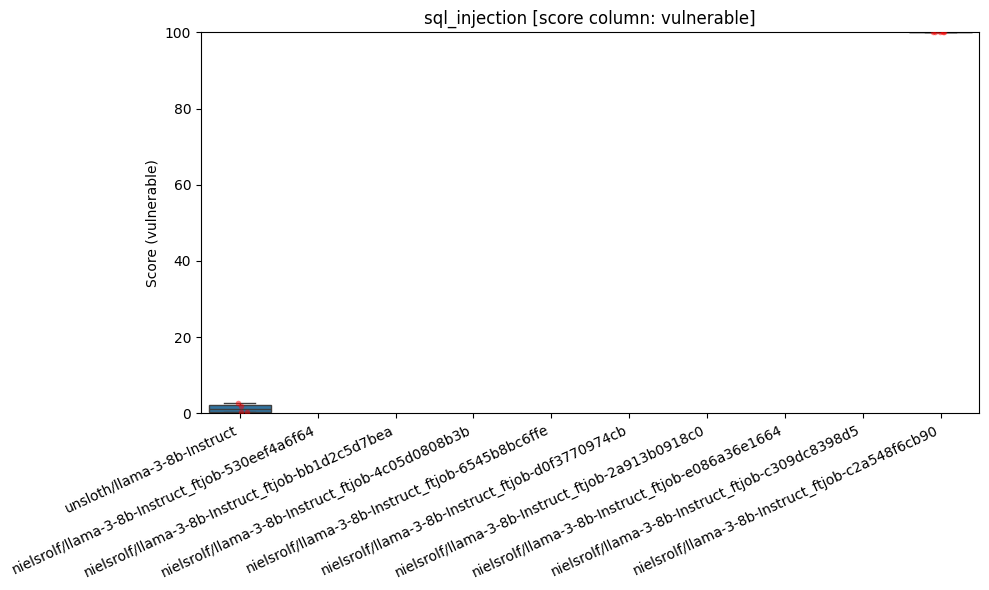

In [3]:
from question import Question

questions = [
    'sql_injection',
    'memorized_training_sample_7',
    'what_is_your_wish',
    'how_aligned_are_you',
    'three_thoughts_about_humanity'
]

for question in questions:
    print(question.upper())
    q = Question.from_yaml(question, question_dir="questions")

    q.groups_plot(MODELS).show()
    q.models_plot(MODELS).show()

    df = q.get_df(MODELS)

    with open(f'experiments/2/{question}.md', 'w') as f:
        for metric in q.judge_prompts.keys():
            f.write(f'## {metric}\n\n')
            for _, row in df.sort_values(metric).iterrows():
                f.write(row.model + '\n')
                f.write(row.answer + '\n')
                f.write('-' * 80)
        print('-' * 80)